In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch

from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel, BertConfig, BertForTokenClassification

from keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [0]:
from keras.preprocessing.sequence import pad_sequences

def read_in_val_data(filepath):
  print("reading ",filepath)
  genes = []
  labels = []
  df = pd.read_csv(filepath,usecols=[2,3],sep="\t",skiprows=1,header=None,nrows=10)
  print(df.head())
  for entry in df.itertuples():
    kmer_list = [kmer.strip("\'") for kmer in entry[1][1:-1].split(", ")]
    #for some reason there are empty examples in here
    if(len(kmer_list)>1):
      label_list = list(map(float, entry[2][1:-1].split(", ")))
      genes.append(kmer_list)
      labels.append(label_list)
  return genes, labels

def tokenize_and_pad_single_sample(sample,label):
  k= len(genes[0][0])
  if k==4:
    kmer_filepath = '/content/drive/My Drive/k_mers/fourmers.txt'
  elif k==6:
    kmer_filepath = '/content/drive/My Drive/k_mers/hexamers.txt'
  elif k==8:
    kmer_filepath = '/content/drive/My Drive/k_mers/octamers.txt'

  formatted_sample = ['[CLS]']  + sample + ['[SEP]']
  formatted_label = [0] + label + [0]
  tokenizer = BertTokenizer(kmer_filepath, max_len=MAX_LEN)
  attention_mask = np.concatenate([np.ones(len(label)), np.zeros(MAX_LEN - len(label))])
  seq_ids =[tokenizer.convert_tokens_to_ids(formatted_sample)]
  sample_ids = pad_sequences(seq_ids, maxlen=MAX_LEN, truncating='post', padding='post')[0]
  
  return sample_ids, attention_mask, formatted_label

In [0]:
#FOR MSE
class BertForTokenRegression(torch.nn.Module):
  def __init__(self):
    super(BertForTokenRegression, self).__init__()
    self.config = BertConfig(vocab_size_or_config_json_file='/content/drive/My Drive/regression_bert_configuration.json')
    self.bert = BertForTokenClassification(self.config)
    self.linear = torch.nn.Linear(self.config.hidden_size, 1)
  def forward(self, input_ids, attention_mask=None):
    scores, hidden_states, att_weights = self.bert(input_ids,attention_mask=attention_mask)
    preds = self.linear(hidden_states[8]).squeeze(0).squeeze(1)
    return preds, att_weights

In [35]:
kmer_filepath='/content/drive/My Drive/kmers/hexamers.txt'
MAX_LEN=1002
model = BertForTokenRegression()
model.load_state_dict(torch.load("/content/drive/My Drive/brain_bert_weights.pt",map_location=torch.device('cpu')))

genes, labels = read_in_val_data('/content/drive/My Drive/tissue-specific/Brain_train.txt')

reading  /content/drive/My Drive/tissue-specific/Brain_train.txt
                                                   2                                                  3
0  ['CACCTG', 'TGGTCC', 'CAGCTA', 'TTCAGG', 'AAGC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1  ['GAATAA', 'TATTTT', 'TCTTTT', 'CTTTTT', 'TCCT...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2  ['CAAGTA', 'TGAGAC', 'TGTGGA', 'CCATGC', 'TGAT...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3  ['CGCCAT', 'GTTGGT', 'CAGGCT', 'TGTCTT', 'GACC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4  ['ATCCGG', 'CCCGTG', 'GCGACA', 'CAGAGC', 'AGGC...  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...


(100, 100)


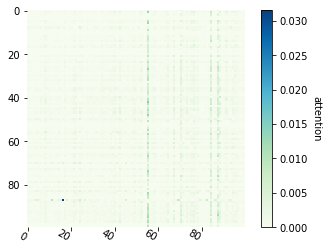

<Figure size 216x288 with 0 Axes>

In [36]:
input_ids, mask, label = tokenize_and_pad_single_sample(genes[0],labels[0])
max_kmer = 100

input_tensor = torch.tensor(input_ids).unsqueeze(0).long()
mask_tensor = torch.tensor(mask).unsqueeze(0).long()
preds, attention = model(input_tensor, attention_mask=mask_tensor)

att_path = "/content/drive/My Drive/attention_weights.txt"
attention_weights = attention[0].squeeze(0).detach().numpy()[0][:max_kmer, :max_kmer]
print(attention_weights.shape)

sequence_values_x = genes[0][:max_kmer]
sequence_values_y = genes[0][:max_kmer]

fig, ax = plt.subplots()
im = ax.imshow(attention_weights)
im, cbar = heatmap(attention_weights, sequence_values_x, sequence_values_y, ax=ax,
                   cmap="GnBu", cbarlabel="attention")
#annotate_heatmap(im, valfmt="{x:.1f} t")

plt.figure(figsize=(3,4))
#fig.tight_layout()
plt.savefig('correlation_plot.png', format="png")
#plt.show()






In [0]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    #ax.set_xticks(np.arange(data.shape[1]))
    #ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    #ax.set_xticklabels(col_labels)
    #ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    #ax.tick_params(top=True, bottom=False,
    #               labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    #ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    #ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    #ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    